In [1]:
import os
import numpy as np
import galsim
import sys
import descwl
import argparse

import copy
%matplotlib inline
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

import tensorflow as tf

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

In [11]:
# Keep an object in the center

def random_sample(Args, catalog):
    """Randomly picks entries from input catlog that are brighter than 25.3
    mag in the i band, keeping one centered. The other objects are randomly
    distributed an annulus around the center of the stamp.
    """
    number_of_objects = np.random.randint(2, Args.max_number)
    q, = np.where(catalog['i_ab'] <= 25.3)
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = btk.create_blend_generator.get_random_center_shift(Args, number_of_objects-1,
                                                                maxshift_stamp_frac=0.4, minshift_stamp_frac=0.05, radial=True)
    blend_catalog['ra'][1:] += dx
    blend_catalog['dec'][1:] += dy
    return blend_catalog

In [12]:
import multiprocessing
pool = multiprocessing.Pool()

batch_size_gen = multiprocessing.cpu_count()

# Load parameters
param = config.Simulation_params(catalog_name, max_number=4, batch_size=batch_size_gen, stamp_size=12)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catlog(catalog_name)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, sampling_function=random_sample)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator, pool=pool) 

Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not v

In [14]:
output_shape = next(draw_blend_generator)['blend_images'].shape

In [18]:
import tensorflow as tf

n_train = 5000
n_val = 500
n_train_batches = n_train / batch_size_gen
n_val_batches = n_val / batch_size_gen
batch_size = 32

def _draw_gen(n):
    count = 0
    while count < n:
        res = next(draw_blend_generator)
        yield (res['blend_images'], res['isolated_images'][:,0])
        count += 1

dset = tf.data.Dataset.from_generator(_draw_gen, (tf.float64, tf.float64),
                                      output_shapes=(tf.TensorShape(output_shape), tf.TensorShape(output_shape)),
                                      args=[n_train_batches])
dset = dset.cache(filename=os.path.join(os.getcwd(), 'cache', 'cache_train_v3'))
dset = dset.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
dset = dset.repeat()
dset = dset.shuffle(buffer_size=n_train)
dset = dset.batch(batch_size)
dset = dset.prefetch(1)

dset_val = tf.data.Dataset.from_generator(_draw_gen, (tf.float64, tf.float64),
                                          output_shapes=(tf.TensorShape(output_shape), tf.TensorShape(output_shape)),
                                          args=[n_val_batches])
dset_val = dset_val.cache(filename=os.path.join(os.getcwd(), 'cache', 'cache_val_v3'))
dset_val = dset_val.flat_map(lambda arg, *rest: tf.data.Dataset.from_tensor_slices((arg,) + rest))
dset_val = dset_val.repeat()
dset_val = dset_val.shuffle(buffer_size=n_val)
dset_val = dset_val.batch(batch_size)
dset_val = dset_val.prefetch(1)

In [21]:
from tensorflow.keras.layers import Input, Dense, Conv2D, PReLU, BatchNormalization, Add
from tensorflow.keras import Model

In [22]:
def simple_residual(x, nfilters):
    h = Conv2D(filters=nfilters, kernel_size=(3,3), padding='same')(x)
    h = BatchNormalization()(h)
    h = PReLU()(h)
    h = Conv2D(filters=int(x.shape[-1]), kernel_size=(3,3), padding='same')(h)
    return Add()([h, x])

def branch_residual(x, nfilters_mid, n_filters_out):
    h = Conv2D(filters=nfilters_mid, kernel_size=(3,3), padding='same')(x)
    h = BatchNormalization()(h)
    h = PReLU()(h)
    h = Conv2D(filters=n_filters_out, kernel_size=(3,3), padding='same')(h)
    y = Conv2D(filters=n_filters_out, kernel_size=(1,1), padding='same')(x)
    return Add()([h, y])

In [23]:
n_res = 3
nfilters = 16

x = Input(shape=output_shape[1:], name='input')

h = BatchNormalization()(x)
h = Conv2D(nfilters, (3,3), padding='same')(x)
h = PReLU()(h)
for i in range(n_res):
    nfilters *= 2
    h = branch_residual(h, nfilters, nfilters)
#     h = simple_residual(h, nfilters)

y = Conv2D(output_shape[-1], (3,3), padding='same')(h)

model = Model(x,y)

In [24]:
model.compile('adam', loss='mse')

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 60, 60, 6)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 16)   880         input[0][0]                      
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 60, 60, 16)   57600       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 60, 32)   4640        p_re_lu[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [26]:
n_plot = 8 #total number is n_plot*batch_size
plot_draw_gen = _draw_gen(n_plot)
_plot_data = [x for x in plot_draw_gen]
plot_data = (np.vstack([x[0] for x in _plot_data]), np.vstack([x[1] for x in _plot_data]))

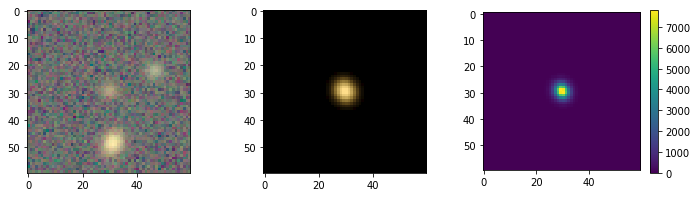

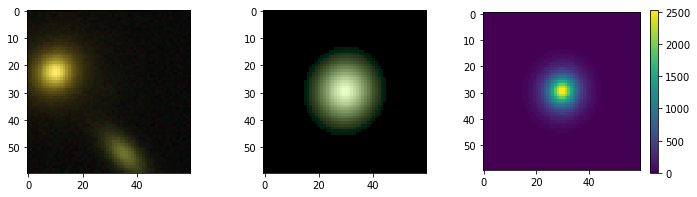

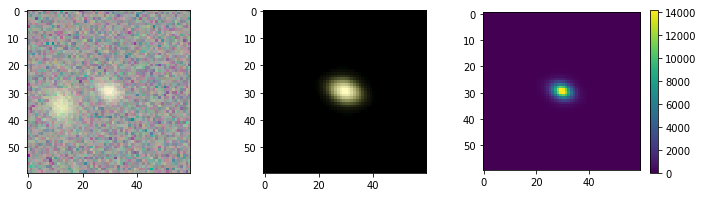

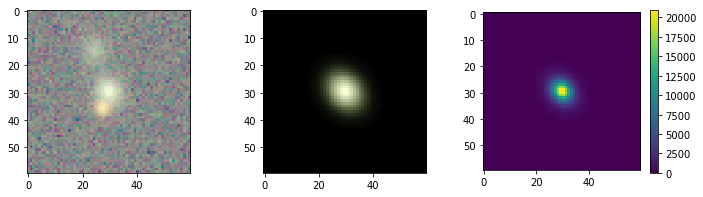

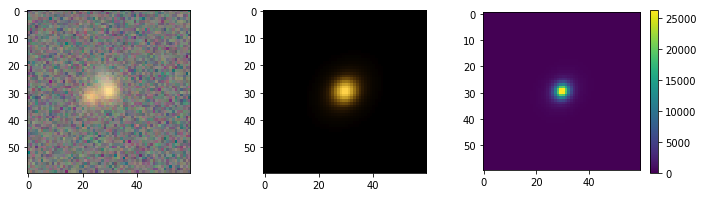

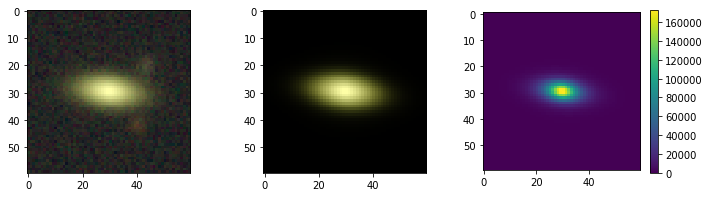

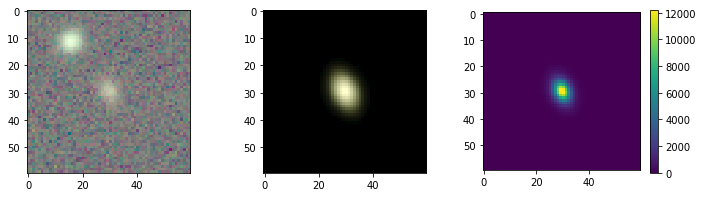

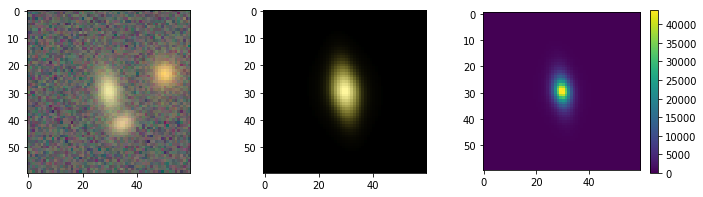

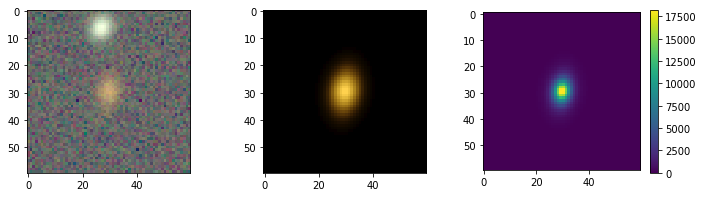

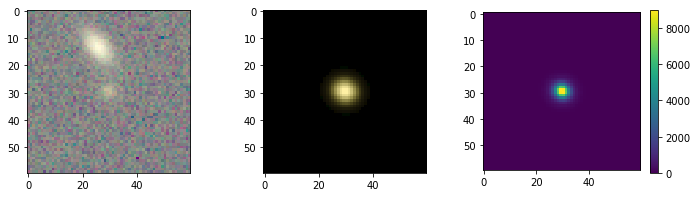

In [27]:
def img_to_rgb(img):
    images = np.transpose(img[:, :, 1:4], axes=(2,0,1))
    norm = scarlet.display.Asinh(img=images, Q=20)
    return scarlet.display.img_to_rgb(images, norm=norm)

for i in range(10):
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].imshow(img_to_rgb(plot_data[0][i]))
    axes[1].imshow(img_to_rgb(plot_data[1][i]))
    ax = axes[2]
    im = ax.imshow(np.sum(plot_data[1][i], axis=2))
    fig.colorbar(im, ax=ax)
#     for ax in axes:
#         ax.set_xlim(30,90)
#         ax.set_ylim(30,90)

In [28]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class LearningPlot(Callback):
    def __init__(self, plot_data):
        self.plot_data = plot_data
        
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):        
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

        clear_output(wait=True)
        
        fig, axes = plt.subplots(1, 4, figsize=(12,3))
        
        ax = axes[0]
        ax.plot(self.loss, c='b')
        ax.plot(self.val_loss, c='r')
        ax.set_xlabel('epoch')
        ax.set_title('Training/validation losses')
        
#         def all_positive(list):
#             return all([x>0. for x in list])
#         if all_positive(self.loss) and all_positive(self.val_loss):
#             ax.set_yscale('log')
        
        idx = np.random.randint(len(self.plot_data[0]))
    
        ax = axes[1]
        ax.imshow(img_to_rgb(self.plot_data[0][idx]))
        ax.set_title('input')
        
        ax = axes[2]
        ax.imshow(img_to_rgb(self.plot_data[1][idx]))
        ax.set_title('target')
        
        ax = axes[3]
        output = model.predict(self.plot_data[0][[idx]])[0]
        ax.imshow(img_to_rgb(output))
        ax.set_title('output')
        
        for i in range(1,4):
            ax.axis('off')
        
        plt.show();
       

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import datetime

learning_plot = LearningPlot(plot_data)

filepath = os.path.join(os.getcwd(), 'models',
                    'weights_'+datetime.datetime.now().strftime("%Y%m%d-%H%M")+'.{epoch:02d}.hdf5')
model_checkpoint = ModelCheckpoint(filepath=filepath, period=5, save_weights_only=True, save_best_only=False)

reduce_lr = ReduceLROnPlateau()

callbacks = [learning_plot, model_checkpoint, reduce_lr]

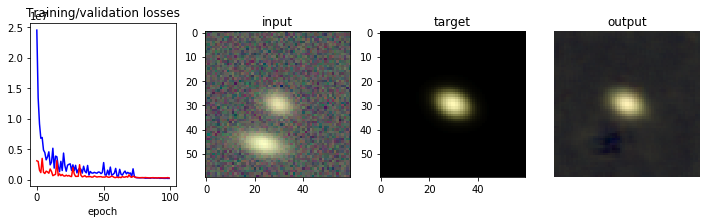


Consider using a TensorFlow optimizer from `tf.train`.


1250/1250 [==============================] - 218s 175ms/step - loss: 235869.9480 - val_loss: 301629.7502


In [30]:
history = model.fit(dset, epochs=100, steps_per_epoch=n_train_batches,
                    validation_data=dset_val, validation_steps=n_val_batches,
                    callbacks=callbacks)

In [31]:
output = model.predict(plot_data[0])

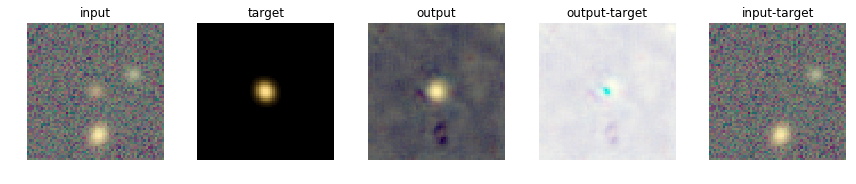

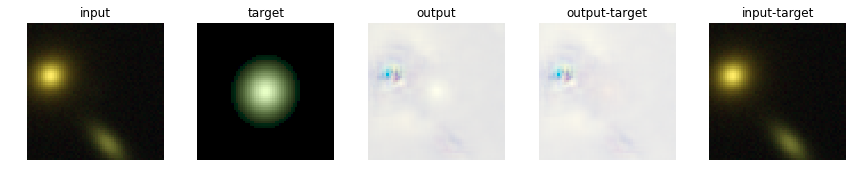

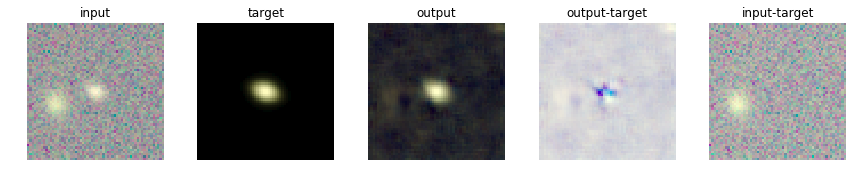

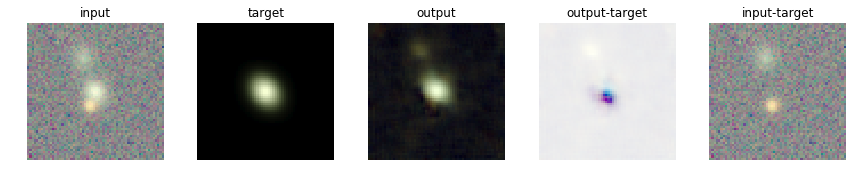

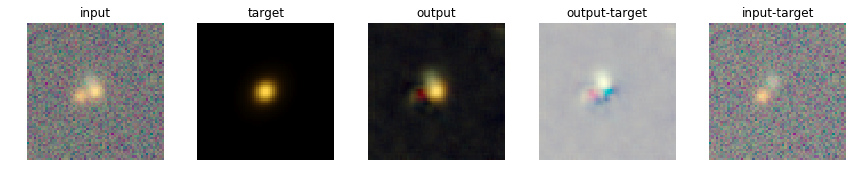

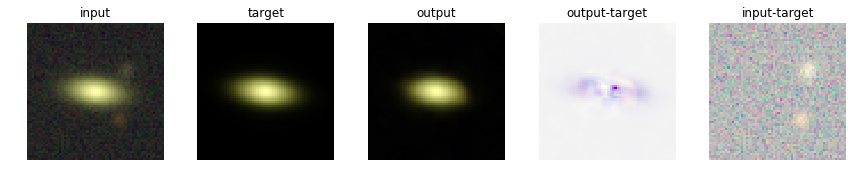

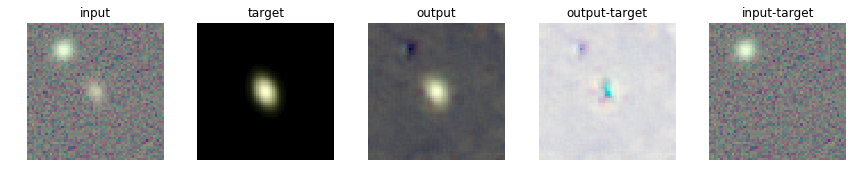

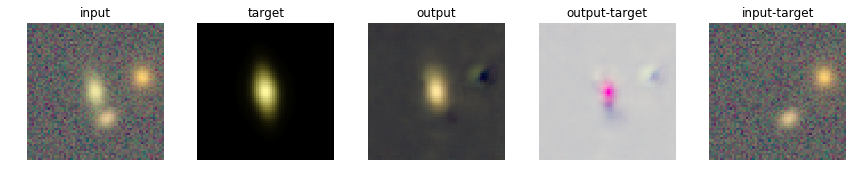

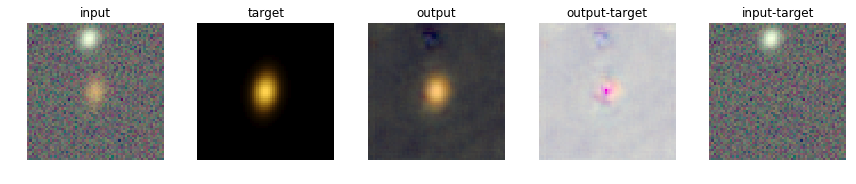

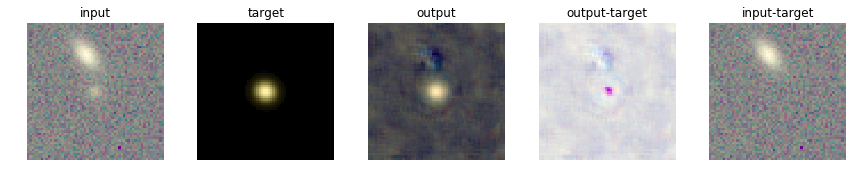

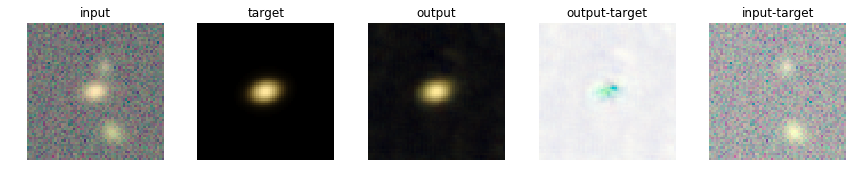

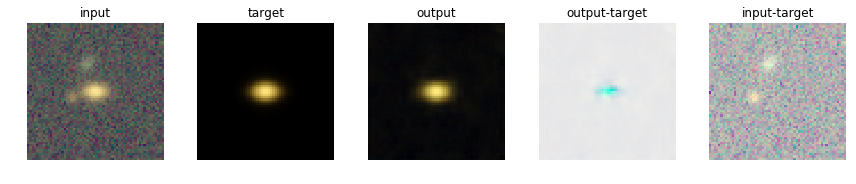

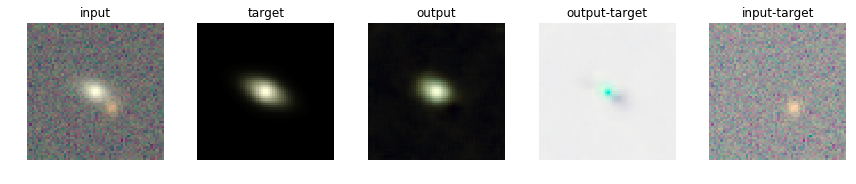

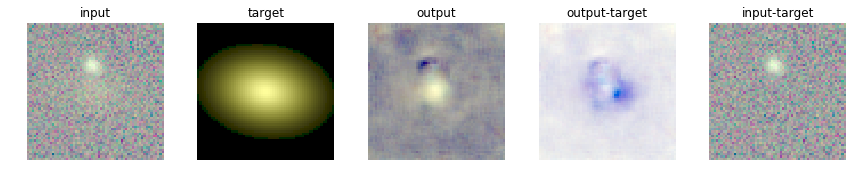

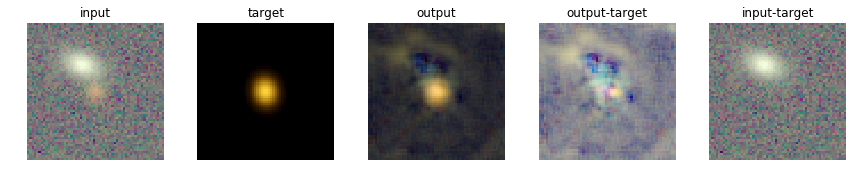

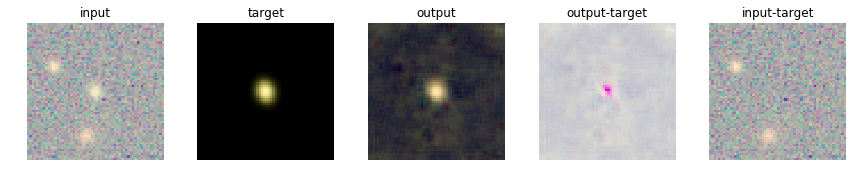

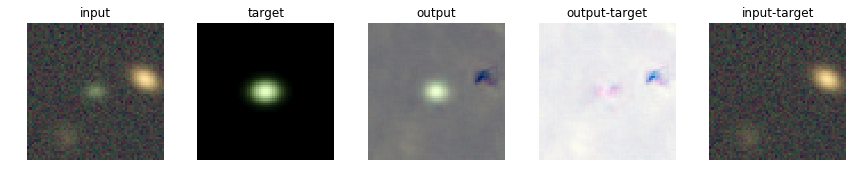

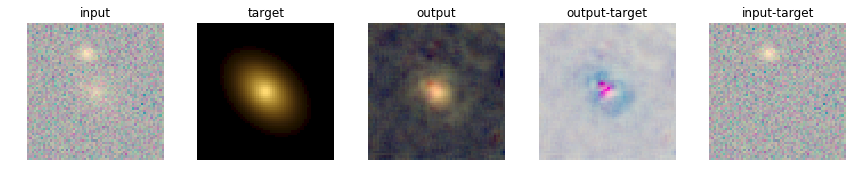

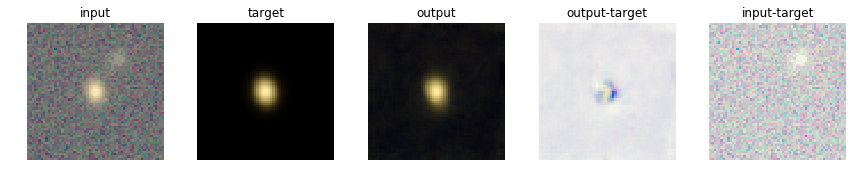

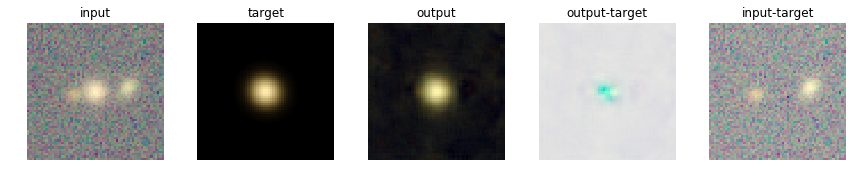

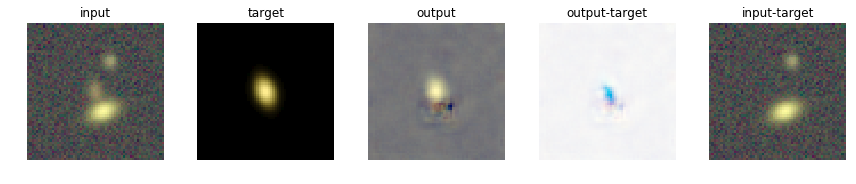

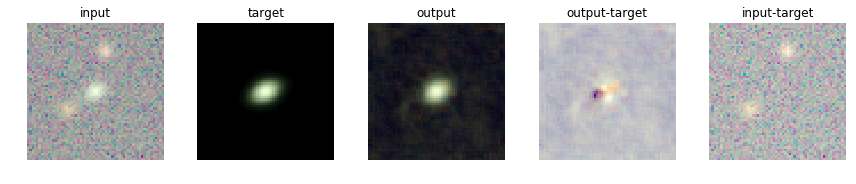

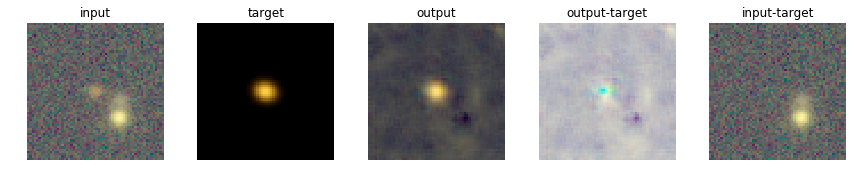

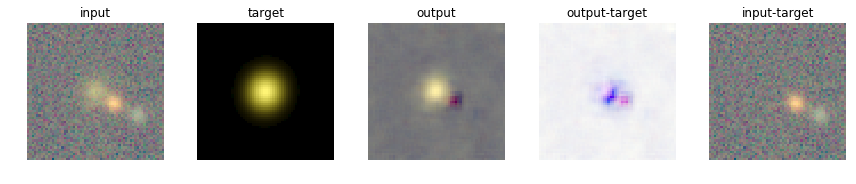

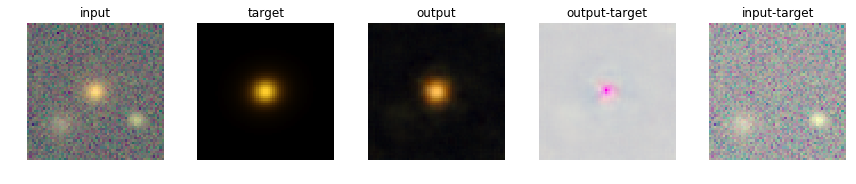

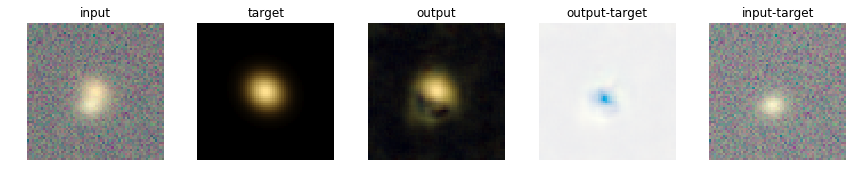

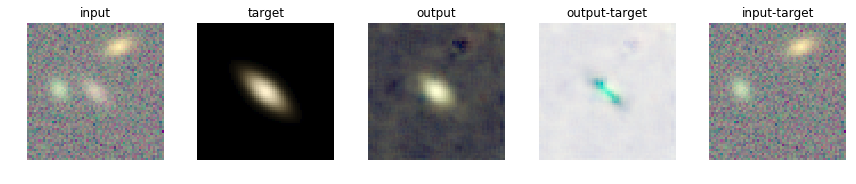

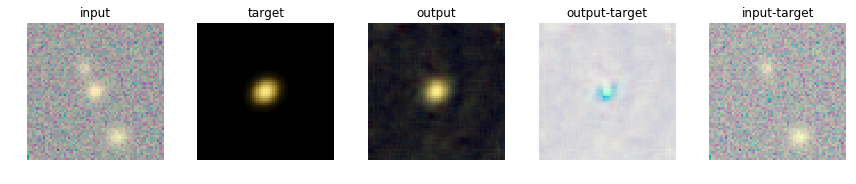

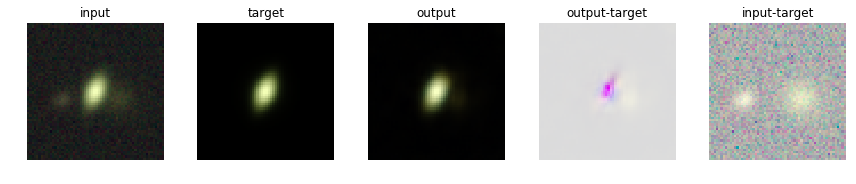

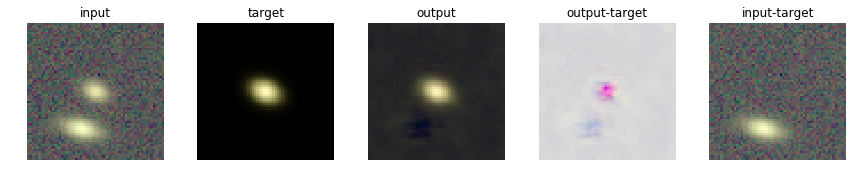

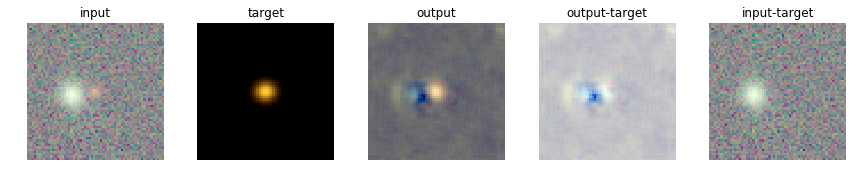

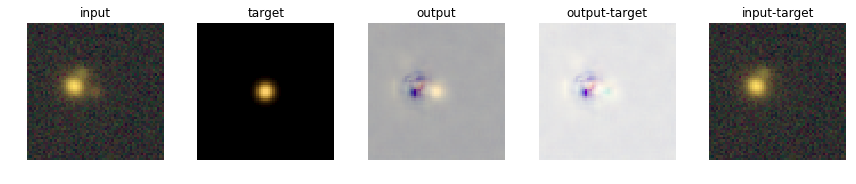

In [32]:
for idx in range(len(output)):
    fig, axes = plt.subplots(1,5, figsize=(12,4))
    ax = axes[0]
    ax.imshow(img_to_rgb(plot_data[0][idx]))
    ax.set_title('input')
    
    ax = axes[1]
    ax.imshow(img_to_rgb(plot_data[1][idx]))
    ax.set_title('target')

    ax = axes[2]
    ax.imshow(img_to_rgb(output[idx]))
    ax.set_title('output')
    
    ax = axes[3]
    ax.imshow(img_to_rgb(output[idx]-plot_data[1][idx]))
    ax.set_title('output-target')
    
    ax = axes[4]
    ax.imshow(img_to_rgb(plot_data[0][idx]-plot_data[1][idx]))
    ax.set_title('input-target')

    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    
    plt.show();